In [1]:
import pandas as pd
import numpy as np

import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

### Задача 1
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [2]:
# Dataset sourse https://archive.ics.uci.edu/ml/datasets/Wine+Quality
w_wine_df = pd.read_csv('./input/winequality-white.csv', delimiter=';')

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'alcohol']
w_wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [3]:
w_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


#### В данных нет пропусков, и все признаки носят количественный характер

In [4]:
w_wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


#### Как видно из статистик ряд признаков имеют выбросы.  

#### В качестве целевой переменной возьмем quality.

In [5]:
w_wine_df['quality'].value_counts().sort_values()

9       5
3      20
4     163
8     175
7     880
5    1457
6    2198
Name: quality, dtype: int64

#### Для построения бинарной классификации изменим целевую переменную

In [6]:
w_wine_df['high_quality'] = w_wine_df['quality'].apply(lambda x: 1 if x >= 7 else 0)
target = 'high_quality'
w_wine_df[target].value_counts().sort_values()

1    1060
0    3838
Name: high_quality, dtype: int64

#### Посмотрим на распределение признаков, для отбора выбросов

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>, <AxesSubplot:>]],
      dtype=object)

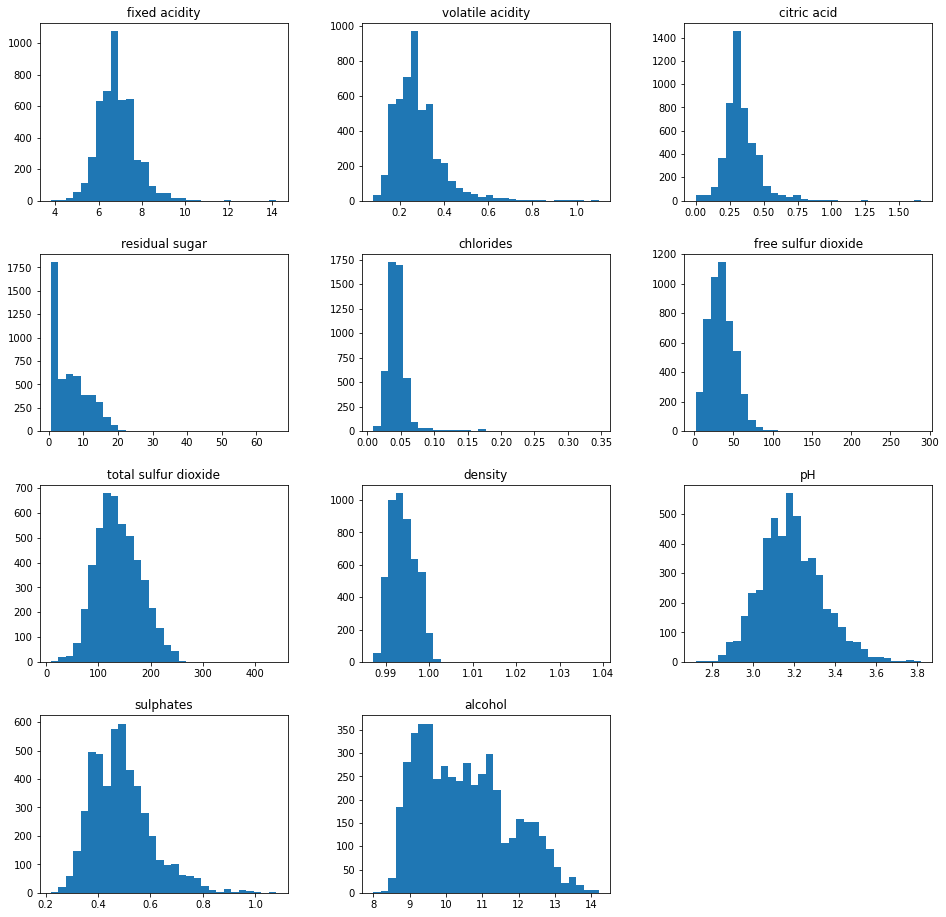

In [7]:
w_wine_df[features].hist(figsize=(16, 16), bins=30, grid=False)

In [8]:
fixed_acidity_outliner = w_wine_df['fixed acidity'] >= 12 
volatile_acidity_outliner = w_wine_df['volatile acidity'] >= 0.9
citric_acid_outliner = w_wine_df['citric acid'] >= 1.3
residual_sugar_outliner = w_wine_df['residual sugar'] >= 23 
chlorides_outliner = w_wine_df['chlorides'] >= 0.11 
free_sulfur_dioxide_outliner = w_wine_df['free sulfur dioxide'] >= 110
total_sulfur_dioxide_outliner = w_wine_df['total sulfur dioxide'] >= 300 
density_outliner = w_wine_df['density'] >= 1.01

outliners = (fixed_acidity_outliner | volatile_acidity_outliner | citric_acid_outliner | 
             residual_sugar_outliner | chlorides_outliner | free_sulfur_dioxide_outliner | 
             total_sulfur_dioxide_outliner | density_outliner)
w_wine_clear_df = w_wine_df.loc[~outliners]

#### Посмотрим на распределение после исключения выбросов

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>, <AxesSubplot:>]],
      dtype=object)

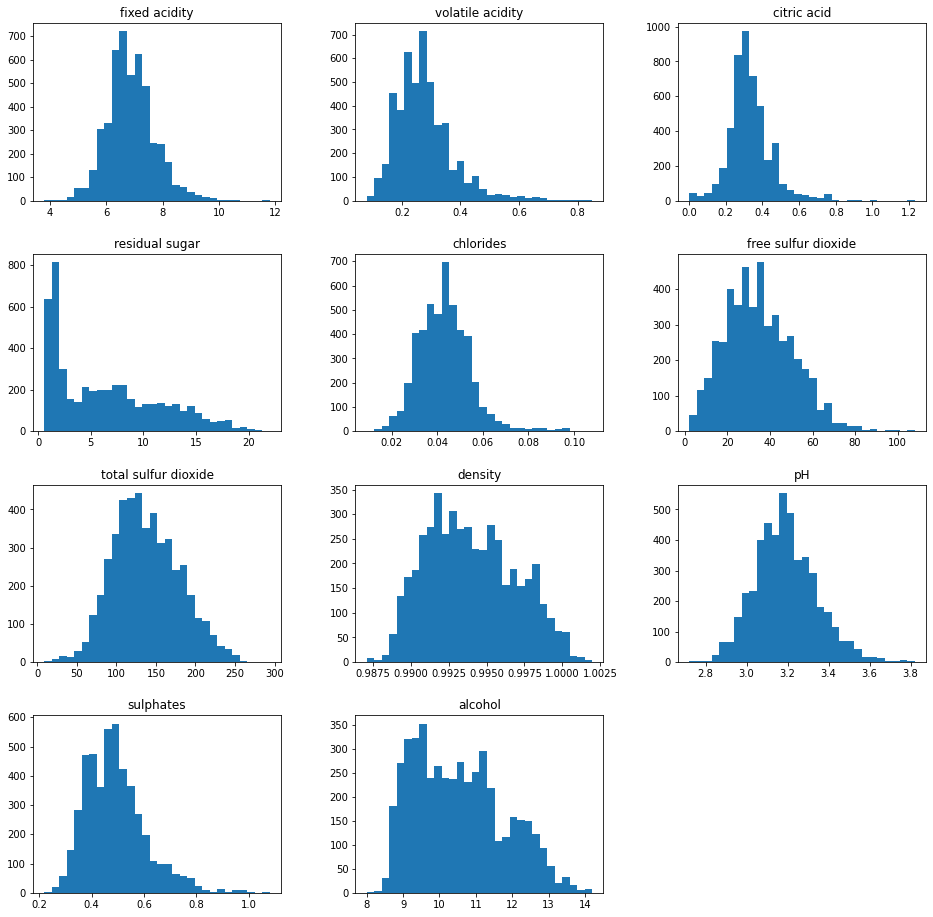

In [9]:
w_wine_clear_df[features].hist(figsize=(16, 16), bins=30, grid=False)

#### Почти все признаки визуально похожи на нормальные, так что теперь посмотрим на взаимосвязь признаков

<AxesSubplot:>

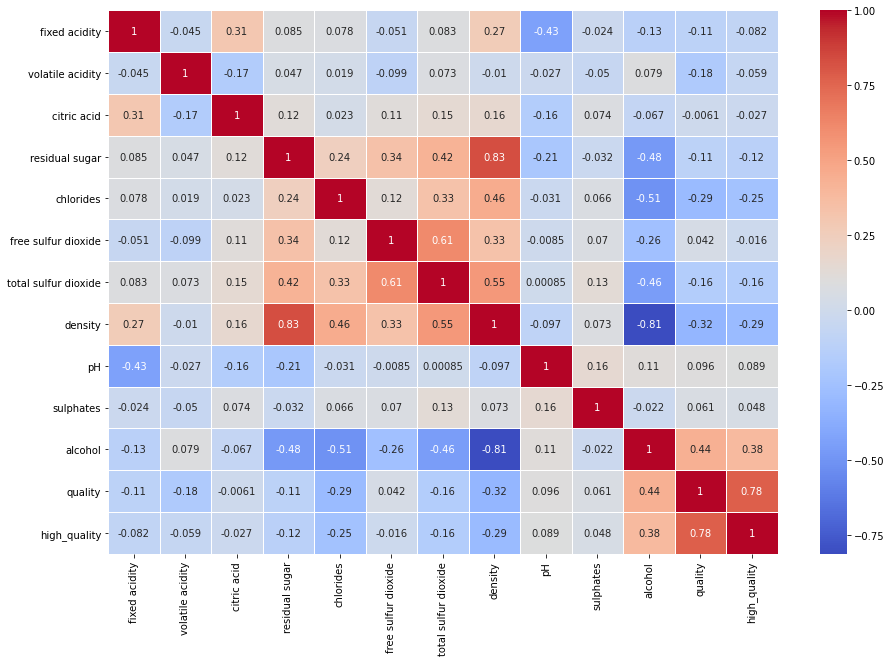

In [10]:
plt.figure(figsize=(15, 10))
corr_matrix = w_wine_clear_df.corr()
sn.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

#### Плотность ('density') имеет высокую корреляцию с признаками алкоголь ('alcohol') и остаточный сахар('residual sugar')

In [11]:
pca = PCA(n_components=1, random_state=6)
density_sugar = ['density', 'residual sugar']
w_wine_clear_df['density sugar'] = pca.fit_transform(w_wine_clear_df[density_sugar])

density_alcohol = ['density', 'alcohol']
w_wine_clear_df['density alcohol'] = pca.fit_transform(w_wine_clear_df[density_alcohol])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

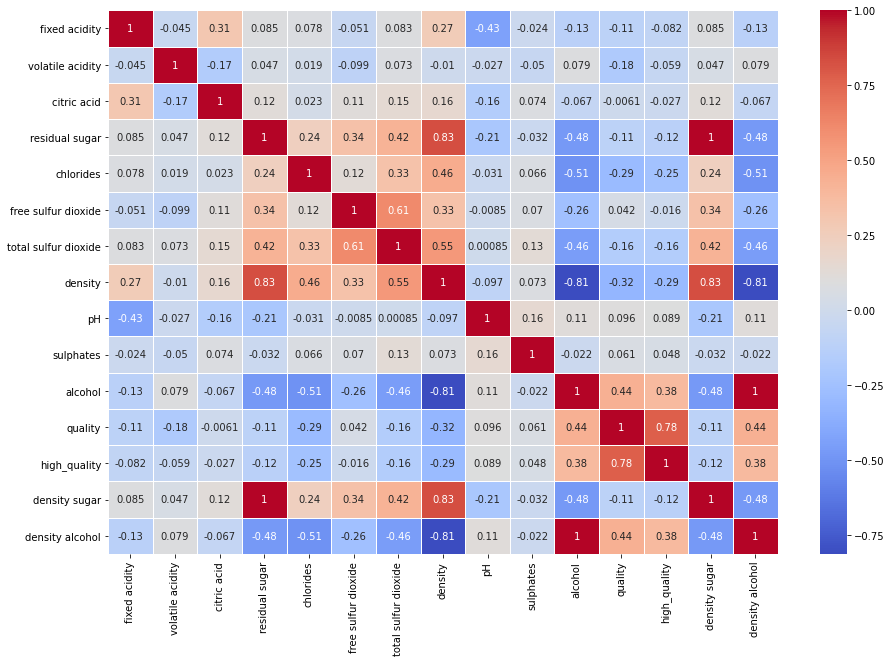

In [12]:
plt.figure(figsize=(15, 10))
corr_matrix = w_wine_clear_df.corr()
sn.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

In [13]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
            'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'density sugar', 'density alcohol']

In [14]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(w_wine_clear_df[features], w_wine_clear_df[target], random_state=6)

In [15]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

model = xgboost.train({"learning_rate": 0.01}, dtrain, 100)
preds = model.predict(dtest)

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.371499, F-Score=0.623, Precision=0.534, Recall=0.748


In [17]:
preds

array([0.19313774, 0.19151822, 0.18497434, ..., 0.19100884, 0.4731573 ,
       0.3822982 ], dtype=float32)

In [18]:
ten_perc = int(len(preds) * 0.1)
top_ten_idx = preds.argsort()[-ten_perc:][::-1]

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

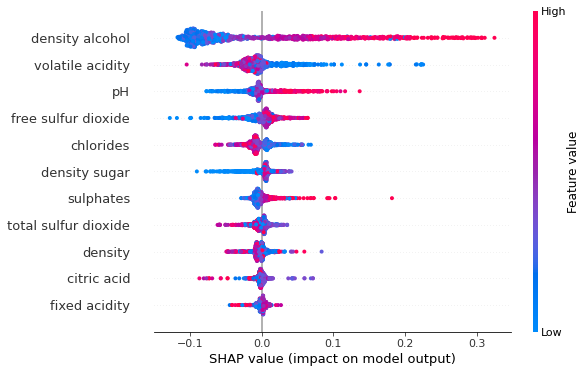

In [20]:
shap.summary_plot(shap_values, X_test)

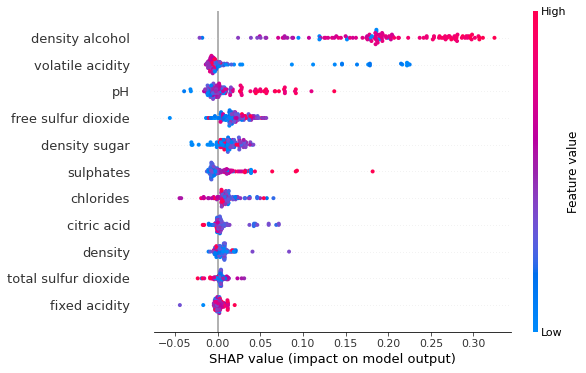

In [21]:
shap_values = explainer.shap_values(X_test.iloc[top_ten_idx])
shap.summary_plot(shap_values, X_test.iloc[top_ten_idx])

#### На графиках видно что в целом наибольшее влияние на качества вина оказывает соотношение плотности и алкоголя

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [23]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

#### Для объекта 6 существенное влияние на качество оказывали признаки соотношение плотности к алкоголю и общее количество диоксида серы. 
#### В тоже время уровень свободного диоксида оказал на качество негативное влияние, так же как и уровень хлора и соотношение сахара к плотности

In [24]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])

#### Для объекта 11 существенное влияние на качество оказывали количество летучей кислота и общее количество диоксида серы. 
#### В тоже время соотношение плотности к алкоголю и количество сульфатов оказали на качество негативное влияние.

In [25]:
shap.force_plot(explainer.expected_value, shap_values[7,:], X_test.iloc[7,:])

#### Для объекта 8 существенное влияние на качество оказывали количество летучей кислота и соотношение плотности к алкоголю и в меньшей степени содержание лимонной кислоты 